In [2]:
!pip install -r requirements.txt


Available countries: Index(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antarctica',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       ...
       'Uruguay', 'Uzbekistan', 'Vanuatu', 'Venezuela', 'Vietnam',
       'West Bank and Gaza', 'Winter Olympics 2022', 'Yemen', 'Zambia',
       'Zimbabwe'],
      dtype='object', name='Country/Region', length=201)
Data type for country column: Country/Region
Afghanistan             object
Albania                 object
Algeria                 object
Andorra                 object
Angola                  object
                         ...  
West Bank and Gaza      object
Winter Olympics 2022    object
Yemen                   object
Zambia                  object
Zimbabwe                object
Length: 201, dtype: object


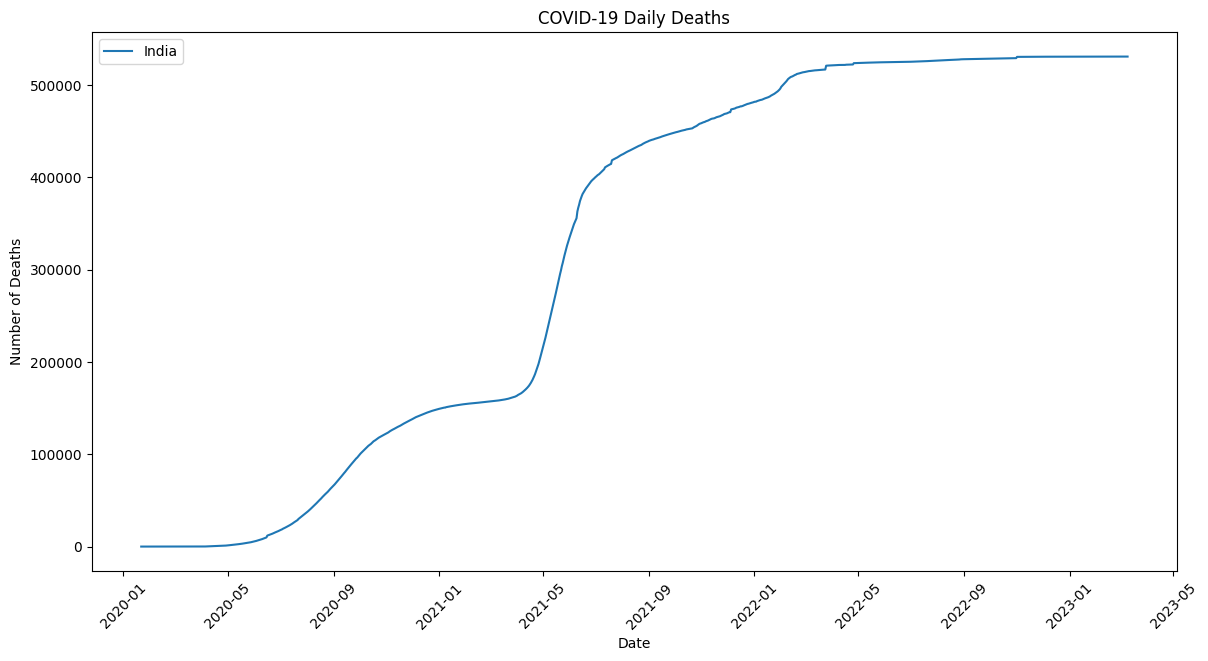

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset from the uploaded file
data = pd.read_csv("C:/VS Studio projects/LSTM TIME SERIES/time_series_covid19_deaths_global.csv")

# Convert column names to datetime
date_columns = pd.to_datetime(data.columns[4:], format='%m/%d/%y', errors='coerce')
data.columns = ['Province/State', 'Country/Region', 'Lat', 'Long'] + list(date_columns)

# Prepare the data for plotting
data_country = data.groupby('Country/Region').sum()
data_country = data_country.drop(['Lat', 'Long'], axis=1)
data_country = data_country.transpose()  # Transpose to have dates as rows

# Ensure the index is in DatetimeIndex format
data_country.index = pd.to_datetime(data_country.index, format='%m/%d/%y', errors='coerce')

# Check available countries and types
print("Available countries:", data_country.columns)
print("Data type for country column:", data_country.dtypes)

# Clean data by ensuring all values are numeric
data_country = data_country.apply(pd.to_numeric, errors='coerce')

# Plot the data for a specific country (e.g., United Kingdom)
country = 'India'  # Change to the desired country
if country in data_country.columns:
    plt.figure(figsize=(14, 7))
    plt.plot(data_country.index, data_country[country], label=country)
    plt.title('COVID-19 Daily Deaths')
    plt.xlabel('Date')
    plt.ylabel('Number of Deaths')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()
else:
    print(f"Country '{country}' not found in the dataset.")


In [5]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

country = 'India'
if country not in data_country.columns:
    raise ValueError(f"Country '{country}' not found in the dataset.")
country



'India'

In [6]:
# Extract the time series data for the selected country
country_data = data_country[country].values
country_data


array([     0,      0,      0, ..., 530775, 530776, 530779], dtype=int64)

In [7]:

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
country_data = scaler.fit_transform(country_data.reshape(-1, 1))
country_data

array([[0.        ],
       [0.        ],
       [0.        ],
       ...,
       [0.99999246],
       [0.99999435],
       [1.        ]])

In [8]:

# Convert the time series data into sequences (X) and corresponding labels (y)
def create_sequences(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)


# Define the number of time steps (lags)
time_steps = 10  # You can experiment with different values

In [9]:

# Create the sequences
X, y = create_sequences(country_data, time_steps)

# Reshape X to be [samples, time steps, features] as required by LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

In [10]:


# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (907, 10, 1)
Testing data shape: (227, 10, 1)


In [11]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Initialize the model
model = Sequential()

# Add an LSTM layer with 50 units (you can experiment with different numbers)
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))

# Add a Dense layer with 1 unit (since we're predicting a single value)
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
model.summary()


c:\VS Studio projects\Udemy final\python\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.1182 - val_loss: 0.0074
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.0913e-04 - val_loss: 2.0300e-05
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0774e-04 - val_loss: 1.7611e-05
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.3245e-05 - val_loss: 2.6148e-06
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.7103e-05 - val_loss: 7.4489e-07
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.5186e-05 - val_loss: 4.4389e-07
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.7735e-05 - val_loss: 6.0877e-07
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.0877e-05 - val_loss: 2.5646e-06
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.8701e-05 - val_loss: 3.0786e-06
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.0964e-05 - val_loss: 2.5732e-06
E

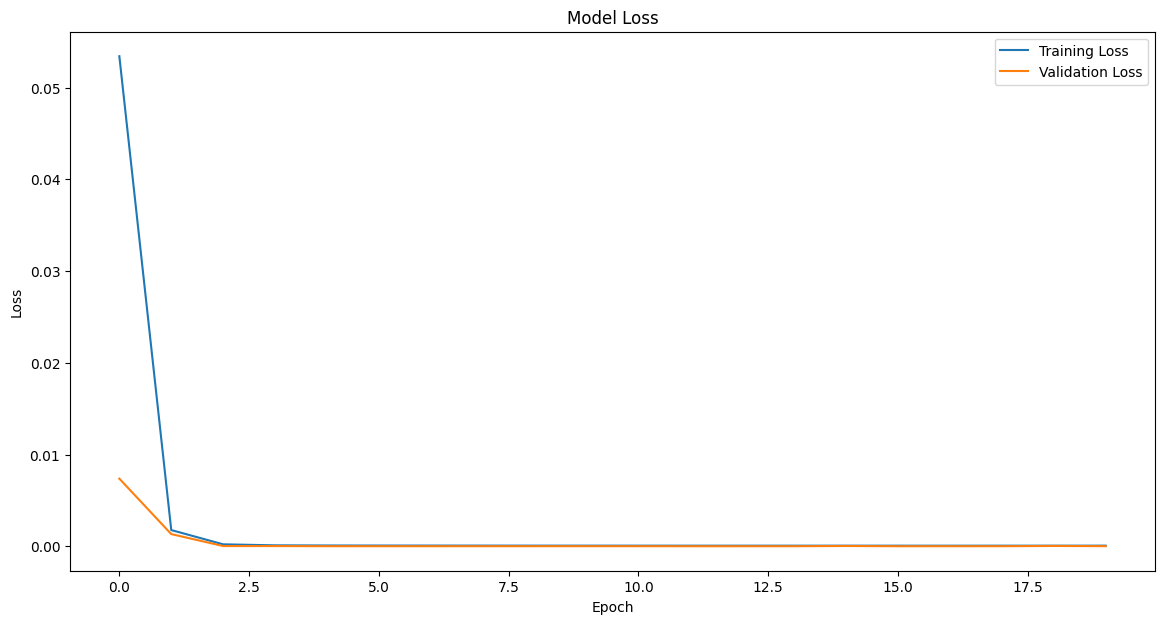

In [12]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Plot training & validation loss values
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Test Loss: 8.138250450429041e-06
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


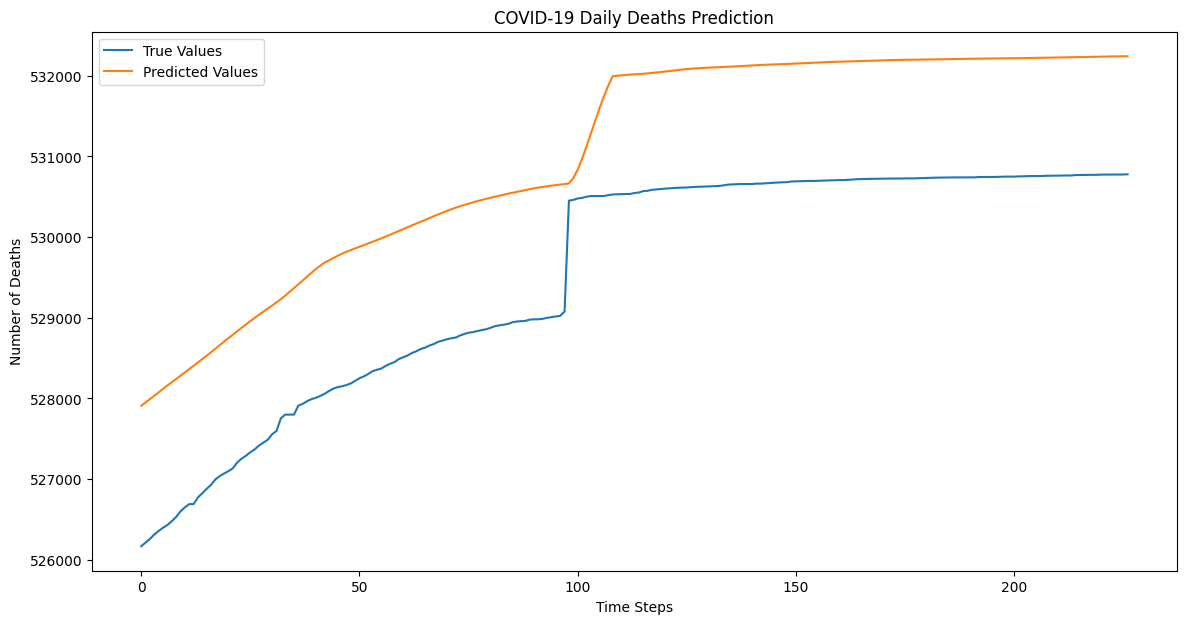

In [13]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}")

# Make predictions on the test set
y_pred = model.predict(X_test)

# Inverse transform the predictions and true values to the original scale
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('COVID-19 Daily Deaths Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Number of Deaths')
plt.legend()
plt.show()


In [14]:
!pip install streamlit
!pip install pyngrok


   ---------------------------------------- 0.0/156.3 kB ? eta -:--:--
   ------------------------------- -------- 122.9/156.3 kB 2.4 MB/s eta 0:00:01
   ---------------------------------------- 156.3/156.3 kB 2.4 MB/s eta 0:00:00


In [15]:
# Save the trained model
model.save('lstm_covid19_model.h5')

print("Model saved as 'lstm_covid19_model.h5'")


Model saved as 'lstm_covid19_model.h5'
